## Imports

In [1]:
%matplotlib inline
from utils import *
from plotting import *
from models import *

## Load Dataset (e.g., Animal-AI_v3)

In [2]:
dataset, pose = load_dataset('dataset_animalai3', file_format='.npy', load_pose=True, pose_filename='pose.npy')

In [3]:
position = pose[:,:2]
orientation = pose[:,2]

In [4]:
print(dataset.shape, pose.shape)

(20000, 84, 84, 3) (20000, 3)


### Occupancy map

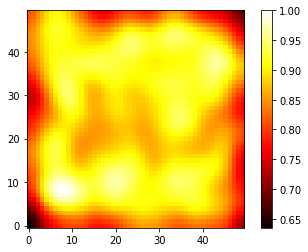

In [5]:
occ_map = occupancy_map(position, filter_width=3)
plt.imshow(occ_map, cmap='hot', origin='lower')
plt.colorbar()

## Autoencoder Grid Search

In [6]:
training_sizes = [500, 1000, 2000, 5000]
sparsity_weights = [1e-3, 1e-2, 1e-1, 1]
n_exp_cond = 5

loss_gridsearch = np.zeros((len(training_sizes), len(sparsity_weights), n_exp_cond))
SI_gridsearch = np.zeros((len(training_sizes), len(sparsity_weights), n_exp_cond))
n_fields_gridsearch = np.zeros((len(training_sizes), len(sparsity_weights), n_exp_cond))
lin_scores_gridsearch = np.zeros((len(training_sizes), len(sparsity_weights), n_exp_cond))
for i, t_size in enumerate(training_sizes):
    print('')
    print('training size: ', t_size)
    for j, s_weight in enumerate(sparsity_weights):
        print('sparsity weight: ', s_weight)
        for z in range(n_exp_cond):
            model = Conv_AE(n_hidden=100, sparsity=False)
            
            indxs_data = np.random.choice(np.arange(dataset.shape[0]), size=t_size, replace=False)
            dataset_reduced = dataset[indxs_data, :]
            position_reduced = position[indxs_data, :]
            
            train_loader = create_dataloader(dataset_reduced, batch_size=64)
            
            history, _ = train_autoencoder(model, train_loader, num_epochs=300, learning_rate=1e-3, device='cuda', 
                                           L2_weight_decay=0, L1_lambda=0, orth_alpha=s_weight, model_type='AE', verbose=False)
            
            loss_gridsearch[i,j,z] = history[-1]
            
            embeddings = get_latent_vectors(dataset_reduced, model)
            
            all_ratemaps = ratemaps(embeddings, position_reduced, n_bins=50, filter_width=3, occupancy_map=occ_map)
            
            SI = spatial_information(all_ratemaps, occ_map)
            SI_gridsearch[i,j,z] = np.mean(SI[np.nonzero(SI)])
            
            n_fields, centroids, sizes = stats_place_fields(all_ratemaps)
            n_fields_gridsearch[i,j,z] = np.mean(n_fields)
            
            lin_score, baseline_score = linear_decoding_score(embeddings, position_reduced, n_baseline=50)
            lin_scores_gridsearch[i,j,z] = lin_score/(baseline_score[0])


training size:  500
sparsity weight:  0.001


Epoch 68/300, Loss: 0.0198: 100%|████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 49.83it/s]


Epoch 136/300, Loss: 0.0172: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 50.73it/s]


Epoch 204/300, Loss: 0.0161: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 48.79it/s]


Epoch 272/300, Loss: 0.0153: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 49.63it/s]


Epoch 40/300, Loss: 0.0251: 100%|████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 45.25it/s]


Epoch 108/300, Loss: 0.0222: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 48.32it/s]


Epoch 176/300, Loss: 0.0210: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 48.22it/s]


Epoch 244/300, Loss: 0.0201: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 47.05it/s]


Epoch 12/300, Loss: 0.0366: 100%|████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 49.02it/s]


Epoch 80/300, Loss: 0.0183: 100%|████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 47.41it/s]


Epoch 148/300, Loss: 0.0163: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 48.33it/s]


Epoch 216/300, Loss: 0.0155: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 47.18it/s]


Epoch 284/300, Loss: 0.0149: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 43.25it/s]


Epoch 52/300, Loss: 0.0224: 100%|████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 46.97it/s]


Epoch 120/300, Loss: 0.0199: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 41.46it/s]


Epoch 188/300, Loss: 0.0186: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 45.68it/s]


Epoch 256/300, Loss: 0.0176: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.32it/s]


Epoch 24/300, Loss: 0.0305: 100%|████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 47.84it/s]


Epoch 92/300, Loss: 0.0226: 100%|████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 47.58it/s]


Epoch 160/300, Loss: 0.0212: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 46.41it/s]


Epoch 228/300, Loss: 0.0201: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 46.48it/s]


Epoch 296/300, Loss: 0.0193: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 46.22it/s]


  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

sparsity weight:  0.01


Epoch 68/300, Loss: 0.1058: 100%|████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 45.76it/s]


Epoch 136/300, Loss: 0.1023: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 46.24it/s]


Epoch 204/300, Loss: 0.1001: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 46.09it/s]


Epoch 272/300, Loss: 0.1003: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 45.80it/s]


Epoch 40/300, Loss: 0.1158: 100%|████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 47.23it/s]


Epoch 108/300, Loss: 0.1115: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.66it/s]


Epoch 176/300, Loss: 0.1092: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 42.03it/s]


Epoch 244/300, Loss: 0.1081: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 43.67it/s]


Epoch 12/300, Loss: 0.1273: 100%|████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 47.72it/s]


Epoch 80/300, Loss: 0.1048: 100%|████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 38.93it/s]


Epoch 148/300, Loss: 0.1021: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 45.75it/s]


Epoch 216/300, Loss: 0.1006: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.21it/s]


Epoch 284/300, Loss: 0.0997: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.38it/s]


Epoch 52/300, Loss: 0.1070: 100%|████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 44.20it/s]


Epoch 120/300, Loss: 0.1021: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 46.40it/s]


Epoch 188/300, Loss: 0.1002: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 44.25it/s]


Epoch 256/300, Loss: 0.0988: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 45.53it/s]


Epoch 24/300, Loss: 0.1152: 100%|████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 46.68it/s]


Epoch 92/300, Loss: 0.1002: 100%|████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 46.68it/s]


Epoch 160/300, Loss: 0.0953: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 46.56it/s]


Epoch 228/300, Loss: 0.0941: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 46.97it/s]


Epoch 296/300, Loss: 0.0919: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 43.55it/s]


  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

sparsity weight:  0.1


Epoch 68/300, Loss: 0.9577: 100%|████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 46.26it/s]


Epoch 136/300, Loss: 0.9330: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 45.74it/s]


Epoch 204/300, Loss: 0.9264: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 44.34it/s]


Epoch 272/300, Loss: 0.9260: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 44.66it/s]


Epoch 40/300, Loss: 0.9821: 100%|████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 46.54it/s]


Epoch 108/300, Loss: 0.9458: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 44.59it/s]


Epoch 176/300, Loss: 0.9366: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 45.72it/s]


Epoch 244/300, Loss: 0.9358: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 45.98it/s]


Epoch 12/300, Loss: 1.0247: 100%|████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 46.11it/s]


Epoch 80/300, Loss: 0.9410: 100%|████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 45.49it/s]


Epoch 148/300, Loss: 0.9136: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 46.77it/s]


Epoch 216/300, Loss: 0.8993: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 44.52it/s]


Epoch 284/300, Loss: 0.8890: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 45.06it/s]


Epoch 52/300, Loss: 0.9683: 100%|████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 46.40it/s]


Epoch 120/300, Loss: 0.9487: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 45.38it/s]


Epoch 188/300, Loss: 0.9289: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 46.27it/s]


Epoch 256/300, Loss: 0.9254: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 45.70it/s]


Epoch 24/300, Loss: 0.9865: 100%|████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 44.86it/s]


Epoch 92/300, Loss: 0.9291: 100%|████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 46.17it/s]


Epoch 160/300, Loss: 0.9088: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 45.52it/s]


Epoch 228/300, Loss: 0.8987: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 46.01it/s]


Epoch 296/300, Loss: 0.8926: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 46.12it/s]


  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

sparsity weight:  1


Epoch 68/300, Loss: 9.0964: 100%|████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 47.38it/s]


Epoch 136/300, Loss: 8.8544: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 45.46it/s]


Epoch 204/300, Loss: 8.8175: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 45.94it/s]


Epoch 272/300, Loss: 8.7779: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 45.77it/s]


Epoch 40/300, Loss: 9.7183: 100%|████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 46.27it/s]


Epoch 108/300, Loss: 9.3893: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.76it/s]


Epoch 176/300, Loss: 9.2463: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 46.24it/s]


Epoch 244/300, Loss: 8.7586: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 44.16it/s]


Epoch 12/300, Loss: 9.9555: 100%|████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 46.06it/s]


Epoch 80/300, Loss: 9.2302: 100%|████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 47.19it/s]


Epoch 148/300, Loss: 8.9976: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 45.74it/s]


Epoch 216/300, Loss: 8.8004: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 45.81it/s]


Epoch 284/300, Loss: 8.8157: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 45.92it/s]


Epoch 52/300, Loss: 9.5505: 100%|████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 45.85it/s]


Epoch 120/300, Loss: 8.6883: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 46.56it/s]


Epoch 188/300, Loss: 8.6023: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 46.08it/s]


Epoch 256/300, Loss: 8.6999: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 45.69it/s]


Epoch 24/300, Loss: 9.9319: 100%|████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 43.56it/s]


Epoch 92/300, Loss: 9.7878: 100%|████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 46.90it/s]


Epoch 160/300, Loss: 9.7961: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 46.29it/s]


Epoch 228/300, Loss: 9.7919: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 40.92it/s]


Epoch 296/300, Loss: 9.7918: 100%|███████████████████████████████████████████████████████| 8/8 [00:00<00:00, 45.66it/s]


  0%|                                                                                           | 0/16 [00:00<?, ?it/s]


training size:  1000
sparsity weight:  0.001


Epoch 68/300, Loss: 0.0191: 100%|██████████████████████████████████████████████████████| 16/16 [00:00<00:00, 43.09it/s]


Epoch 136/300, Loss: 0.0173: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 45.57it/s]


Epoch 204/300, Loss: 0.0165: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 46.08it/s]


Epoch 272/300, Loss: 0.0161: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 44.90it/s]


Epoch 40/300, Loss: 0.0211: 100%|██████████████████████████████████████████████████████| 16/16 [00:00<00:00, 46.69it/s]


Epoch 108/300, Loss: 0.0182: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 45.54it/s]


Epoch 176/300, Loss: 0.0170: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 45.33it/s]


Epoch 244/300, Loss: 0.0165: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 44.90it/s]


Epoch 12/300, Loss: 0.0283: 100%|██████████████████████████████████████████████████████| 16/16 [00:00<00:00, 45.95it/s]


Epoch 80/300, Loss: 0.0198: 100%|██████████████████████████████████████████████████████| 16/16 [00:00<00:00, 45.98it/s]


Epoch 148/300, Loss: 0.0180: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 44.20it/s]


Epoch 216/300, Loss: 0.0171: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 45.13it/s]


Epoch 284/300, Loss: 0.0165: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 45.45it/s]


Epoch 52/300, Loss: 0.0188: 100%|██████████████████████████████████████████████████████| 16/16 [00:00<00:00, 45.86it/s]


Epoch 120/300, Loss: 0.0164: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 40.07it/s]


Epoch 188/300, Loss: 0.0157: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 45.69it/s]


Epoch 256/300, Loss: 0.0151: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 45.41it/s]


Epoch 24/300, Loss: 0.0232: 100%|██████████████████████████████████████████████████████| 16/16 [00:00<00:00, 44.45it/s]


Epoch 92/300, Loss: 0.0201: 100%|██████████████████████████████████████████████████████| 16/16 [00:00<00:00, 45.72it/s]


Epoch 160/300, Loss: 0.0184: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 27.83it/s]


Epoch 228/300, Loss: 0.0176: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 38.93it/s]


Epoch 296/300, Loss: 0.0171: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 43.57it/s]


Epoch 300/300, Loss: 0.0172: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 36.97it/s]


sparsity weight:  0.01


Epoch 68/300, Loss: 0.1068: 100%|██████████████████████████████████████████████████████| 16/16 [00:00<00:00, 46.73it/s]


Epoch 136/300, Loss: 0.1044: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 45.87it/s]


Epoch 204/300, Loss: 0.1034: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 45.49it/s]


Epoch 272/300, Loss: 0.1027: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 45.16it/s]


Epoch 40/300, Loss: 0.1084: 100%|██████████████████████████████████████████████████████| 16/16 [00:00<00:00, 45.50it/s]


Epoch 108/300, Loss: 0.1050: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 45.53it/s]


Epoch 176/300, Loss: 0.1037: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 45.70it/s]


Epoch 244/300, Loss: 0.1029: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 46.13it/s]


Epoch 12/300, Loss: 0.1154: 100%|██████████████████████████████████████████████████████| 16/16 [00:00<00:00, 46.23it/s]


Epoch 80/300, Loss: 0.1050: 100%|██████████████████████████████████████████████████████| 16/16 [00:00<00:00, 45.37it/s]


Epoch 148/300, Loss: 0.1031: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 43.49it/s]


Epoch 216/300, Loss: 0.1020: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 42.77it/s]


Epoch 284/300, Loss: 0.1012: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 38.91it/s]


Epoch 52/300, Loss: 0.1048: 100%|██████████████████████████████████████████████████████| 16/16 [00:00<00:00, 43.15it/s]


Epoch 120/300, Loss: 0.0997: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 42.89it/s]


Epoch 188/300, Loss: 0.0972: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 43.59it/s]


Epoch 256/300, Loss: 0.0967: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 39.51it/s]


Epoch 24/300, Loss: 0.1075: 100%|██████████████████████████████████████████████████████| 16/16 [00:00<00:00, 42.57it/s]


Epoch 92/300, Loss: 0.0998: 100%|██████████████████████████████████████████████████████| 16/16 [00:00<00:00, 44.96it/s]


Epoch 160/300, Loss: 0.0982: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 46.25it/s]


Epoch 228/300, Loss: 0.0970: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 43.53it/s]


Epoch 296/300, Loss: 0.0965: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 44.98it/s]


Epoch 300/300, Loss: 0.0964: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 45.75it/s]


sparsity weight:  0.1


Epoch 68/300, Loss: 0.9519: 100%|██████████████████████████████████████████████████████| 16/16 [00:00<00:00, 38.80it/s]


Epoch 136/300, Loss: 0.9391: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 45.46it/s]


Epoch 204/300, Loss: 0.9277: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 45.05it/s]


Epoch 272/300, Loss: 0.9291: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 44.98it/s]


Epoch 40/300, Loss: 0.9416: 100%|██████████████████████████████████████████████████████| 16/16 [00:00<00:00, 45.11it/s]


Epoch 108/300, Loss: 0.9196: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 45.62it/s]


Epoch 176/300, Loss: 0.9087: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 45.53it/s]


Epoch 244/300, Loss: 0.8992: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 43.30it/s]


Epoch 12/300, Loss: 1.0188: 100%|██████████████████████████████████████████████████████| 16/16 [00:00<00:00, 45.58it/s]


Epoch 80/300, Loss: 0.9850: 100%|██████████████████████████████████████████████████████| 16/16 [00:00<00:00, 42.25it/s]


Epoch 148/300, Loss: 0.9656: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 41.61it/s]


Epoch 216/300, Loss: 0.9617: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 45.68it/s]


Epoch 284/300, Loss: 0.9592: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 41.24it/s]


Epoch 52/300, Loss: 0.9520: 100%|██████████████████████████████████████████████████████| 16/16 [00:00<00:00, 32.95it/s]


Epoch 120/300, Loss: 0.9343: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 45.77it/s]


Epoch 188/300, Loss: 0.9216: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 44.79it/s]


Epoch 256/300, Loss: 0.9210: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 44.57it/s]


Epoch 24/300, Loss: 0.9676: 100%|██████████████████████████████████████████████████████| 16/16 [00:00<00:00, 43.84it/s]


Epoch 92/300, Loss: 0.9357: 100%|██████████████████████████████████████████████████████| 16/16 [00:00<00:00, 38.11it/s]


Epoch 160/300, Loss: 0.9278: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 40.91it/s]


Epoch 228/300, Loss: 0.9165: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 44.82it/s]


Epoch 296/300, Loss: 0.9129: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 45.55it/s]


Epoch 300/300, Loss: 0.9137: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 45.99it/s]


sparsity weight:  1


Epoch 68/300, Loss: 9.9761: 100%|██████████████████████████████████████████████████████| 16/16 [00:00<00:00, 45.28it/s]


Epoch 136/300, Loss: 9.9753: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 46.26it/s]


Epoch 204/300, Loss: 9.9749: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 45.07it/s]


Epoch 272/300, Loss: 9.9749: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 42.20it/s]


Epoch 40/300, Loss: 9.5438: 100%|██████████████████████████████████████████████████████| 16/16 [00:00<00:00, 45.41it/s]


Epoch 108/300, Loss: 9.2893: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 45.59it/s]


Epoch 176/300, Loss: 9.1705: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 44.72it/s]


Epoch 244/300, Loss: 9.1441: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 45.26it/s]


Epoch 12/300, Loss: 9.9758: 100%|██████████████████████████████████████████████████████| 16/16 [00:00<00:00, 46.05it/s]


Epoch 80/300, Loss: 8.8614: 100%|██████████████████████████████████████████████████████| 16/16 [00:00<00:00, 45.96it/s]


Epoch 148/300, Loss: 8.5457: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 45.14it/s]


Epoch 216/300, Loss: 8.4361: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 44.92it/s]


Epoch 284/300, Loss: 8.4749: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 44.95it/s]


Epoch 52/300, Loss: 9.2939: 100%|██████████████████████████████████████████████████████| 16/16 [00:00<00:00, 45.49it/s]


Epoch 120/300, Loss: 8.8088: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 37.59it/s]


Epoch 188/300, Loss: 8.6634: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 38.90it/s]


Epoch 256/300, Loss: 8.6182: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 39.87it/s]


Epoch 24/300, Loss: 9.6948: 100%|██████████████████████████████████████████████████████| 16/16 [00:00<00:00, 41.71it/s]


Epoch 92/300, Loss: 9.2479: 100%|██████████████████████████████████████████████████████| 16/16 [00:00<00:00, 45.46it/s]


Epoch 160/300, Loss: 9.2288: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 35.64it/s]


Epoch 228/300, Loss: 9.1752: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 36.86it/s]


Epoch 296/300, Loss: 9.1220: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 35.88it/s]


Epoch 300/300, Loss: 9.2008: 100%|█████████████████████████████████████████████████████| 16/16 [00:00<00:00, 33.10it/s]



training size:  2000
sparsity weight:  0.001


Epoch 68/300, Loss: 0.0176: 100%|██████████████████████████████████████████████████████| 32/32 [00:00<00:00, 43.62it/s]


Epoch 136/300, Loss: 0.0163: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 40.37it/s]


Epoch 204/300, Loss: 0.0157: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 45.97it/s]


Epoch 272/300, Loss: 0.0154: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 46.02it/s]


Epoch 40/300, Loss: 0.0199: 100%|██████████████████████████████████████████████████████| 32/32 [00:00<00:00, 46.14it/s]


Epoch 108/300, Loss: 0.0180: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 45.08it/s]


Epoch 176/300, Loss: 0.0172: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 44.15it/s]


Epoch 244/300, Loss: 0.0168: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 44.71it/s]


Epoch 12/300, Loss: 0.0266: 100%|██████████████████████████████████████████████████████| 32/32 [00:00<00:00, 38.43it/s]


Epoch 80/300, Loss: 0.0227: 100%|██████████████████████████████████████████████████████| 32/32 [00:00<00:00, 38.48it/s]


Epoch 148/300, Loss: 0.0216: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 38.02it/s]


Epoch 216/300, Loss: 0.0210: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 44.87it/s]


Epoch 284/300, Loss: 0.0204: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 44.18it/s]


Epoch 52/300, Loss: 0.0167: 100%|██████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.73it/s]


Epoch 120/300, Loss: 0.0154: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 45.51it/s]


Epoch 188/300, Loss: 0.0147: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 41.02it/s]


Epoch 256/300, Loss: 0.0143: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 44.08it/s]


Epoch 24/300, Loss: 0.0191: 100%|██████████████████████████████████████████████████████| 32/32 [00:00<00:00, 44.43it/s]


Epoch 92/300, Loss: 0.0159: 100%|██████████████████████████████████████████████████████| 32/32 [00:00<00:00, 43.61it/s]


Epoch 160/300, Loss: 0.0151: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 44.38it/s]


Epoch 228/300, Loss: 0.0147: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 45.07it/s]


Epoch 296/300, Loss: 0.0142: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 41.64it/s]


Epoch 300/300, Loss: 0.0142: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 37.73it/s]


sparsity weight:  0.01


Epoch 68/300, Loss: 0.0999: 100%|██████████████████████████████████████████████████████| 32/32 [00:00<00:00, 44.53it/s]


Epoch 136/300, Loss: 0.0973: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 41.17it/s]


Epoch 204/300, Loss: 0.0957: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 44.81it/s]


Epoch 272/300, Loss: 0.0953: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 45.35it/s]


Epoch 40/300, Loss: 0.1019: 100%|██████████████████████████████████████████████████████| 32/32 [00:00<00:00, 41.48it/s]


Epoch 108/300, Loss: 0.0981: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 46.54it/s]


Epoch 176/300, Loss: 0.0961: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 46.36it/s]


Epoch 244/300, Loss: 0.0953: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 40.23it/s]


Epoch 12/300, Loss: 0.1098: 100%|██████████████████████████████████████████████████████| 32/32 [00:00<00:00, 45.66it/s]


Epoch 80/300, Loss: 0.1026: 100%|██████████████████████████████████████████████████████| 32/32 [00:00<00:00, 44.28it/s]


Epoch 148/300, Loss: 0.1008: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.77it/s]


Epoch 216/300, Loss: 0.1003: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 45.86it/s]


Epoch 284/300, Loss: 0.0999: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 44.79it/s]


Epoch 52/300, Loss: 0.1040: 100%|██████████████████████████████████████████████████████| 32/32 [00:00<00:00, 46.17it/s]


Epoch 120/300, Loss: 0.1016: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 46.39it/s]


Epoch 188/300, Loss: 0.1002: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 44.04it/s]


Epoch 256/300, Loss: 0.0996: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 45.01it/s]


Epoch 24/300, Loss: 0.1151: 100%|██████████████████████████████████████████████████████| 32/32 [00:00<00:00, 44.38it/s]


Epoch 92/300, Loss: 0.1114: 100%|██████████████████████████████████████████████████████| 32/32 [00:00<00:00, 45.16it/s]


Epoch 160/300, Loss: 0.1095: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 45.91it/s]


Epoch 228/300, Loss: 0.1088: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 39.61it/s]


Epoch 296/300, Loss: 0.1081: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 44.53it/s]


Epoch 300/300, Loss: 0.1081: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 44.84it/s]


sparsity weight:  0.1


Epoch 68/300, Loss: 0.9797: 100%|██████████████████████████████████████████████████████| 32/32 [00:00<00:00, 45.26it/s]


Epoch 136/300, Loss: 0.9762: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 44.86it/s]


Epoch 204/300, Loss: 0.9747: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 44.70it/s]


Epoch 272/300, Loss: 0.9751: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 47.82it/s]


Epoch 40/300, Loss: 0.9662: 100%|██████████████████████████████████████████████████████| 32/32 [00:00<00:00, 48.25it/s]


Epoch 108/300, Loss: 0.9632: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 48.25it/s]


Epoch 176/300, Loss: 0.9611: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 47.39it/s]


Epoch 244/300, Loss: 0.9588: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 47.68it/s]


Epoch 12/300, Loss: 0.9802: 100%|██████████████████████████████████████████████████████| 32/32 [00:00<00:00, 46.57it/s]


Epoch 80/300, Loss: 0.8828: 100%|██████████████████████████████████████████████████████| 32/32 [00:00<00:00, 45.19it/s]


Epoch 148/300, Loss: 0.8617: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 43.77it/s]


Epoch 216/300, Loss: 0.8579: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 37.18it/s]


Epoch 284/300, Loss: 0.8464: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 45.57it/s]


Epoch 52/300, Loss: 0.8927: 100%|██████████████████████████████████████████████████████| 32/32 [00:00<00:00, 45.19it/s]


Epoch 120/300, Loss: 0.8779: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 48.47it/s]


Epoch 188/300, Loss: 0.8653: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 47.74it/s]


Epoch 256/300, Loss: 0.8653: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 47.46it/s]


Epoch 24/300, Loss: 1.0196: 100%|██████████████████████████████████████████████████████| 32/32 [00:00<00:00, 48.47it/s]


Epoch 92/300, Loss: 1.0195: 100%|██████████████████████████████████████████████████████| 32/32 [00:00<00:00, 48.40it/s]


Epoch 160/300, Loss: 1.0194: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 44.69it/s]


Epoch 228/300, Loss: 1.0194: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 45.00it/s]


Epoch 296/300, Loss: 1.0194: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 44.56it/s]


Epoch 300/300, Loss: 1.0193: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 44.81it/s]


sparsity weight:  1


Epoch 68/300, Loss: 9.5782: 100%|██████████████████████████████████████████████████████| 32/32 [00:00<00:00, 45.51it/s]


Epoch 136/300, Loss: 9.4094: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 48.39it/s]


Epoch 204/300, Loss: 9.1458: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 49.29it/s]


Epoch 272/300, Loss: 8.9374: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 48.91it/s]


Epoch 40/300, Loss: 8.9947: 100%|██████████████████████████████████████████████████████| 32/32 [00:00<00:00, 49.14it/s]


Epoch 108/300, Loss: 8.8177: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 49.29it/s]


Epoch 176/300, Loss: 8.6859: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 46.10it/s]


Epoch 244/300, Loss: 8.5324: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 48.17it/s]


Epoch 12/300, Loss: 9.8430: 100%|██████████████████████████████████████████████████████| 32/32 [00:00<00:00, 50.69it/s]


Epoch 80/300, Loss: 9.1816: 100%|██████████████████████████████████████████████████████| 32/32 [00:00<00:00, 49.14it/s]


Epoch 148/300, Loss: 9.0956: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 48.99it/s]


Epoch 216/300, Loss: 9.0667: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 49.44it/s]


Epoch 284/300, Loss: 9.0504: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 48.25it/s]


Epoch 52/300, Loss: 10.0248: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 49.59it/s]


Epoch 120/300, Loss: 10.0247: 100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.89it/s]


Epoch 188/300, Loss: 10.0247: 100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 48.03it/s]


Epoch 256/300, Loss: 10.0248: 100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 47.68it/s]


Epoch 300/300, Loss: 10.0247: 100%|████████████████████████████████████████████████████| 32/32 [00:00<00:00, 47.39it/s]
C:\Users\adria\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\adria\miniconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Epoch 21/300, Loss: 9.6948: 100%|██████████████████████████████████████████████████████| 32/32 [00:00<00:00, 48.47it/s]


Epoch 89/300, Loss: 9.0943: 100%|██████████████████████████████████████████████████████| 32/32 [00:00<00:00, 47.67it/s]


Epoch 157/300, Loss: 8.9914: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 47.05it/s]


Epoch 225/300, Loss: 8.9331: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 44.75it/s]


Epoch 293/300, Loss: 8.9015: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 44.75it/s]


Epoch 300/300, Loss: 8.9248: 100%|█████████████████████████████████████████████████████| 32/32 [00:00<00:00, 44.81it/s]



training size:  5000
sparsity weight:  0.001


Epoch 68/300, Loss: 0.0188: 100%|██████████████████████████████████████████████████████| 79/79 [00:01<00:00, 45.13it/s]


Epoch 136/300, Loss: 0.0177: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 44.70it/s]


Epoch 204/300, Loss: 0.0171: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 44.15it/s]


Epoch 272/300, Loss: 0.0168: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 44.90it/s]


Epoch 40/300, Loss: 0.0173: 100%|██████████████████████████████████████████████████████| 79/79 [00:01<00:00, 41.43it/s]


Epoch 108/300, Loss: 0.0160: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 40.68it/s]


Epoch 176/300, Loss: 0.0155: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 44.80it/s]


Epoch 244/300, Loss: 0.0152: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 44.63it/s]


Epoch 12/300, Loss: 0.0215: 100%|██████████████████████████████████████████████████████| 79/79 [00:01<00:00, 45.29it/s]


Epoch 80/300, Loss: 0.0182: 100%|██████████████████████████████████████████████████████| 79/79 [00:01<00:00, 40.72it/s]


Epoch 148/300, Loss: 0.0171: 100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 39.04it/s]


Epoch 216/300, Loss: 0.0165: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 47.35it/s]


Epoch 284/300, Loss: 0.0162: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 47.15it/s]


Epoch 52/300, Loss: 0.0204: 100%|██████████████████████████████████████████████████████| 79/79 [00:01<00:00, 47.66it/s]


Epoch 120/300, Loss: 0.0189: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 47.26it/s]


Epoch 188/300, Loss: 0.0183: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 47.43it/s]


Epoch 256/300, Loss: 0.0179: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 47.12it/s]


Epoch 24/300, Loss: 0.0221: 100%|██████████████████████████████████████████████████████| 79/79 [00:01<00:00, 48.15it/s]


Epoch 92/300, Loss: 0.0198: 100%|██████████████████████████████████████████████████████| 79/79 [00:01<00:00, 43.69it/s]


Epoch 160/300, Loss: 0.0190: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 47.23it/s]


Epoch 228/300, Loss: 0.0186: 100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 37.43it/s]


Epoch 296/300, Loss: 0.0183: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 41.59it/s]


Epoch 300/300, Loss: 0.0183: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 44.35it/s]


sparsity weight:  0.01


Epoch 68/300, Loss: 0.0995: 100%|██████████████████████████████████████████████████████| 79/79 [00:01<00:00, 43.47it/s]


Epoch 136/300, Loss: 0.0968: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 43.96it/s]


Epoch 204/300, Loss: 0.0953: 100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 38.77it/s]


Epoch 272/300, Loss: 0.0946: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 42.37it/s]


Epoch 40/300, Loss: 0.1007: 100%|██████████████████████████████████████████████████████| 79/79 [00:01<00:00, 48.18it/s]


Epoch 108/300, Loss: 0.0970: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 47.92it/s]


Epoch 176/300, Loss: 0.0952: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 47.80it/s]


Epoch 244/300, Loss: 0.0942: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 44.50it/s]


Epoch 12/300, Loss: 0.1093: 100%|██████████████████████████████████████████████████████| 79/79 [00:01<00:00, 43.62it/s]


Epoch 80/300, Loss: 0.1050: 100%|██████████████████████████████████████████████████████| 79/79 [00:01<00:00, 47.28it/s]


Epoch 148/300, Loss: 0.1042: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 48.23it/s]


Epoch 216/300, Loss: 0.1037: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 48.66it/s]


Epoch 284/300, Loss: 0.1032: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.04it/s]


Epoch 52/300, Loss: 0.1055: 100%|██████████████████████████████████████████████████████| 79/79 [00:01<00:00, 47.85it/s]


Epoch 120/300, Loss: 0.1039: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 48.82it/s]


Epoch 188/300, Loss: 0.1030: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 47.59it/s]


Epoch 256/300, Loss: 0.1026: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 48.55it/s]


Epoch 24/300, Loss: 0.1059: 100%|██████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.93it/s]


Epoch 92/300, Loss: 0.1031: 100%|██████████████████████████████████████████████████████| 79/79 [00:01<00:00, 46.63it/s]


Epoch 160/300, Loss: 0.1023: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 42.63it/s]


Epoch 228/300, Loss: 0.1017: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 42.02it/s]


Epoch 296/300, Loss: 0.1015: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 45.46it/s]


Epoch 300/300, Loss: 0.1015: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 46.09it/s]


sparsity weight:  0.1


Epoch 68/300, Loss: 0.8637: 100%|██████████████████████████████████████████████████████| 79/79 [00:01<00:00, 48.49it/s]


Epoch 136/300, Loss: 0.8564: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 49.44it/s]


Epoch 204/300, Loss: 0.8508: 100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 38.70it/s]


Epoch 272/300, Loss: 0.8460: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 44.39it/s]


Epoch 40/300, Loss: 0.9153: 100%|██████████████████████████████████████████████████████| 79/79 [00:01<00:00, 45.28it/s]


Epoch 108/300, Loss: 0.8879: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 39.98it/s]


Epoch 176/300, Loss: 0.8782: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 43.81it/s]


Epoch 244/300, Loss: 0.8776: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 44.15it/s]


Epoch 12/300, Loss: 0.9587: 100%|██████████████████████████████████████████████████████| 79/79 [00:01<00:00, 46.07it/s]


Epoch 80/300, Loss: 0.8982: 100%|██████████████████████████████████████████████████████| 79/79 [00:01<00:00, 44.38it/s]


Epoch 148/300, Loss: 0.8899: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 44.09it/s]


Epoch 216/300, Loss: 0.8825: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 44.77it/s]


Epoch 284/300, Loss: 0.8825: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 44.82it/s]


Epoch 52/300, Loss: 0.8793: 100%|██████████████████████████████████████████████████████| 79/79 [00:01<00:00, 42.02it/s]


Epoch 120/300, Loss: 0.8547: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 40.43it/s]


Epoch 188/300, Loss: 0.8402: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 45.49it/s]


Epoch 256/300, Loss: 0.8373: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 44.64it/s]


Epoch 24/300, Loss: 0.9443: 100%|██████████████████████████████████████████████████████| 79/79 [00:01<00:00, 46.64it/s]


Epoch 92/300, Loss: 0.9220: 100%|██████████████████████████████████████████████████████| 79/79 [00:01<00:00, 46.08it/s]


Epoch 160/300, Loss: 0.9178: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 44.06it/s]


Epoch 228/300, Loss: 0.9075: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 45.48it/s]


Epoch 296/300, Loss: 0.9037: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 45.22it/s]


Epoch 300/300, Loss: 0.9044: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 40.56it/s]


sparsity weight:  1


Epoch 68/300, Loss: 8.7090: 100%|██████████████████████████████████████████████████████| 79/79 [00:02<00:00, 29.84it/s]


Epoch 136/300, Loss: 8.5808: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 43.95it/s]


Epoch 204/300, Loss: 8.5586: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 40.54it/s]


Epoch 272/300, Loss: 8.5302: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 39.69it/s]


Epoch 40/300, Loss: 8.8892: 100%|██████████████████████████████████████████████████████| 79/79 [00:01<00:00, 44.66it/s]


Epoch 108/300, Loss: 8.6342: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 44.57it/s]


Epoch 176/300, Loss: 8.6110: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 42.74it/s]


Epoch 244/300, Loss: 8.5381: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 39.92it/s]


Epoch 12/300, Loss: 9.6182: 100%|██████████████████████████████████████████████████████| 79/79 [00:01<00:00, 45.04it/s]


Epoch 80/300, Loss: 8.9653: 100%|██████████████████████████████████████████████████████| 79/79 [00:01<00:00, 45.28it/s]


Epoch 148/300, Loss: 8.6180: 100%|█████████████████████████████████████████████████████| 79/79 [00:02<00:00, 34.54it/s]


Epoch 216/300, Loss: 8.4361: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 45.52it/s]


Epoch 284/300, Loss: 8.3745: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 45.68it/s]


Epoch 52/300, Loss: 8.4699: 100%|██████████████████████████████████████████████████████| 79/79 [00:01<00:00, 44.59it/s]


Epoch 120/300, Loss: 8.2821: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 42.47it/s]


Epoch 188/300, Loss: 8.2168: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 45.97it/s]


Epoch 256/300, Loss: 8.2092: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 44.30it/s]


Epoch 24/300, Loss: 9.5833: 100%|██████████████████████████████████████████████████████| 79/79 [00:01<00:00, 47.73it/s]


Epoch 92/300, Loss: 9.2248: 100%|██████████████████████████████████████████████████████| 79/79 [00:01<00:00, 46.88it/s]


Epoch 160/300, Loss: 9.0496: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 47.69it/s]


Epoch 228/300, Loss: 8.7571: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 47.66it/s]


Epoch 296/300, Loss: 8.6198: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 47.89it/s]


Epoch 300/300, Loss: 8.6220: 100%|█████████████████████████████████████████████████████| 79/79 [00:01<00:00, 48.45it/s]


In [9]:
loss_gridsearch_avg = np.nanmean(loss_gridsearch, axis=2)
SI_gridsearch_avg = np.nanmean(SI_gridsearch, axis=2)
n_fields_gridsearch_avg = np.nanmean(n_fields_gridsearch, axis=2)
lin_scores_gridsearch_avg = np.nanmean(lin_scores_gridsearch, axis=2)

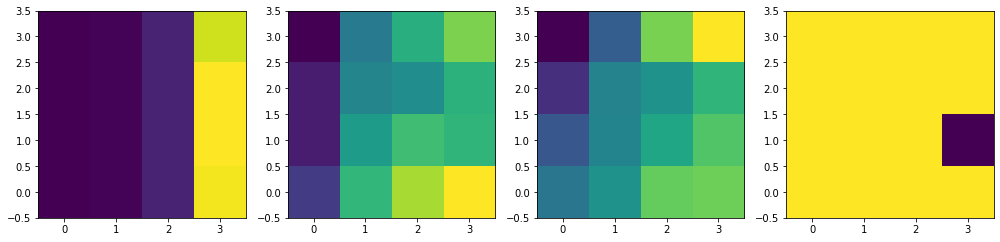

In [13]:
plt.figure(figsize=(14,6))

plt.subplot(141)
plt.imshow(loss_gridsearch_avg, origin='lower')

plt.subplot(142)
plt.imshow(SI_gridsearch_avg, origin='lower')

plt.subplot(143)
plt.imshow(n_fields_gridsearch_avg, origin='lower')

plt.subplot(144)
plt.imshow(lin_scores_gridsearch_avg, origin='lower')

plt.tight_layout()
plt.show()

In [14]:
SI_gridsearch_avg[0,3]

1.3050003648466932

In [15]:
np.max(SI_gridsearch_avg)

1.3050003648466932